## 使用SageMaker+XGBoost，将时间序列转换为监督学习，完成预测性维护的实践
https://github.com/liangyimingcom/Use-SageMaker_XGBoost-convert-Time-Series-into-Supervised-Learning-for-predictive-maintenance

**关键字**：SageMaker；XGBoost；Python；滑窗；滑动窗口方法；时间序列预测转化为监督学习问题；将多元时间序列数据转换为监督学习问题；如何用Python将时间序列问题转化为有监督学习问题；时间序列预测的机器学习模型；Machine Learning；ML；

# SageMaker Hyperparameter Tuning 超参数优化

我们已经准备好数据集，就可以训练模型了。
在执行此操作之前，要注意的一件事是存在称为“超参数”的算法设置，这些设置可能会严重影响训练后的模型的准确度。
例如，XGBoost算法具有几十个超参数，我们需要为这些超参数选择正确的值，以便获得所需的模型训练结果。
由于超参数设置复杂并导致了准确度的变化，因此不可能直接得到最佳超参数设置，SageMaker的超参数优化（Hyperparameter_Tuning），以自动的方法搜索到最佳超参数设置。

我们将使用SageMaker Hyperparameter Tuning来有效地自动执行搜索最佳参数的过程。具体来说，对于超参数，我们可以指定每个超参数指定一个范围或可能值的列表。 SageMaker超参数优化将自动启动具有不同超参数设置的多个训练作业，基于预定义的“结果指标evaluation metric”评估那些训练作业的结果，并根据先前的结果为以后的尝试选择超参数设置。对于每个超参数调整作业，我们将给它一个预算（最大训练作业数），并且在执行完许多训练作业后该预算将完成。

---
### 本章节内容Contents

1. [算法选择构建模型（XGBoost）]
2. [模型训练]
3. [超参数优化(反复调参试错)]
4. [评估Evaluation]
5. [部署模型线上推理]

---


In [45]:
import sagemaker
import boto3
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
import os 
from datetime import datetime
from time import gmtime, strftime, sleep

region = boto3.Session().region_name    
smclient = boto3.Session().client('sagemaker')

role = sagemaker.get_execution_role()

bucket = sagemaker.Session().default_bucket()

# prefix为Step1中，数据预处理后的S3存储桶名称，用于导入训练数据集
##prefix = 'xgb-10000871.csv-TC58-SW100-WC10-20201202080714'
##prefix = 'xgb-10000871.csv-TC58-SW100-WC20-20201202051756'
#prefix = 'xgb-10000871.csv-TC58-SW100-WC40-20201202032834'
##prefix = 'xgb-10000871.csv-TC58-SW100-WC60-20201202011847'
##prefix = 'xgb-10000871.csv-TC58-SW100-WC80-20201202023456'
##prefix = 'xgb-10000871.csv-TC58-SW100-WC99-20201202064356'
prefix = 'xgb-10000871-part_ac.csv-TC58-SW010-WC006-20210405135629' ##for demo 

#获取一个有意义的prefix_tuningjobname，
prefix_tuningjobname = prefix[-31:-15]+'-'+strftime("%Y%m%d%H%M%S", gmtime())
#prefix_tuningjobname = prefix[-30:-15]#+'-'+strftime("%Y%m%d%H%M%S", gmtime())

#for teseting
print(bucket) #S3桶名称
print(prefix) #S3桶名称
print(prefix_tuningjobname) #有意义的直观的训练任务名称


sagemaker-cn-northwest-1-337575217701
xgb-10000871-part_ac.csv-TC58-SW010-WC006-20210405135629
TC58-SW010-WC006-20210405151047


In [2]:
from sagemaker.amazon.amazon_estimator import get_image_uri

sess = sagemaker.Session()

container = get_image_uri(region, 'xgboost', repo_version='1')
#container = get_image_uri(boto3.Session().region_name, 'xgboost')
#display(container)

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m5.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)

xgb.set_hyperparameters(eval_metric='mae',
                        objective='binary:logistic')

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
	get_image_uri(region, 'xgboost', '1.0-1').


### XGBoost使用四个超参数：
* * eta *：在更新中使用步长缩小以防止过度拟合。 在每个增强步骤之后，您都可以直接获得新功能的权重。 eta参数实际上缩小了特征权重，以使提升过程更加保守。
* * alpha *：关于权重的L1正则化项。 增加此值会使模型更加保守。
* * min_child_weight *：子级中实例重量的最小总和（hessian）。 如果树分区步骤导致叶节点的实例权重之和小于min_child_weight，则构建过程将放弃进一步的分区。 在线性回归模型中，这仅对应于每个节点所需的最少实例数。 算法越大，则算法越保守。
* * max_depth *：一棵树的最大深度。 增加此值会使模型更复杂，并且可能会过拟合。

In [3]:
hyperparameter_ranges = {'num_round': IntegerParameter(100, 1000)}

### 评估模型的第一步是要先确立评估的标准——evaluation metric，在这里我们使用XGBoost解决回归问题，选择mae来作为评估标准
我们将指定我们想要调整的客观指标及其定义，其中包括从训练任务的CloudWatch日志中提取该指标所需的正则表达式（Regex）。 由于我们在这里使用内置的XGBoost算法，因此它发出两个预定义的指标：* validation：auc *和* train：auc *，我们选择监视* validation：auc *，如下所示。 在这种情况下，我们只需要指定指标名称即可，而无需提供正则表达式。 如果您带上自己的算法，则算法本身会发出指标。 在这种情况下，您需要在此处添加MetricDefinition对象，以通过正则表达式定义那些指标的格式，以便SageMaker知道如何从CloudWatch日志中提取那些指标。

In [4]:
objective_metric_name = 'validation:mae'


### 创建一个“ HyperparameterTuner”对象，并将其传递给该对象：
- The XGBoost estimator we created above
- Our hyperparameter ranges
- Objective metric name and definition
- Tuning resource configurations such as Number of training jobs to run in total and how many training jobs can be run in parallel.



In [7]:
tuner = HyperparameterTuner(xgb,
                            objective_metric_name,                           
                            hyperparameter_ranges,
                            objective_type='Minimize',
                            base_tuning_job_name=prefix_tuningjobname,
                            max_jobs=9,
                            max_parallel_jobs=3)

### 运行超参数调优 Hyperparameter_Tuning 任务
现在，我们可以通过调用* fit（）*函数来启动超参数调整作业。 创建超参数调整作业后，我们可以转到SageMaker控制台以跟踪超参数调整作业的进度，直到完成为止。

In [8]:
### for solved issue: <AttributeError: module 'sagemaker' has no attribute 's3_input'> only working on sagemaker=  1.68.0 !!!
#!pip list 
#!pip install sagemaker==1.68.0    

In [9]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

tuner.fit({'train': s3_input_train, 'validation': s3_input_validation}, include_cls_metadata=False)

### 让我们对超参数调整作业状态进行 反复 检查，以确保其成功完成。

In [33]:
tuningjobname = tuner.latest_tuning_job.job_name
#print(tuningjobname) #for testing

boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

### 分析超参数调整作业的结果
一旦完成了调优作业，便可以分析结果以了解每个超参数如何影响模型的质量。

In [25]:
import boto3
import sagemaker
import os

region = boto3.Session().region_name
sage_client = boto3.Session().client('sagemaker')

## You must have already run a hyperparameter tuning job to analyze it here.
## The Hyperparameter tuning jobs you have run are listed in the Training section on your SageMaker dashboard.
## Copy the name of a completed job you want to analyze from that list.
## For example: tuning_job_name = 'mxnet-training-201007-0054'.
#tuning_job_name = 'YOUR-HYPERPARAMETER-TUNING-JOB-NAME'
tuning_job_name = tuningjobname

### 跟踪超参数调整作业进度
启动调优作业后，可以通过调用describe_tuning_job API来查看其进度。 describe-tuning-job的输出是一个JSON对象，其中包含有关调整作业的当前状态的信息。 您可以调用list_training_jobs_for_tuning_job来查看调优作业启动的培训作业的详细列表。

In [34]:
# run this cell to check current status of hyperparameter tuning job
tuning_job_result = sage_client.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)

status = tuning_job_result['HyperParameterTuningJobStatus']
if status != 'Completed':
    print('Reminder: the tuning job has not been completed.')
    
job_count = tuning_job_result['TrainingJobStatusCounters']['Completed']
print("%d training jobs have completed" % job_count)
    
is_minimize = (tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['Type'] != 'Maximize')
objective_name = tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['MetricName']

9 training jobs have completed


In [35]:
from pprint import pprint
if tuning_job_result.get('BestTrainingJob',None):
    print("Best model found so far:")
    pprint(tuning_job_result['BestTrainingJob'])
else:
    print("No training jobs have reported results yet.")

Best model found so far:
{'CreationTime': datetime.datetime(2021, 4, 5, 14, 47, 30, tzinfo=tzlocal()),
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:mae',
                                                 'Value': 0.13454200327396393},
 'ObjectiveStatus': 'Succeeded',
 'TrainingEndTime': datetime.datetime(2021, 4, 5, 14, 50, 45, tzinfo=tzlocal()),
 'TrainingJobArn': 'arn:aws-cn:sagemaker:cn-northwest-1:337575217701:training-job/tc58-sw010-wc006-210405-1444-005-f9925ce7',
 'TrainingJobName': 'TC58-SW010-WC006-210405-1444-005-f9925ce7',
 'TrainingJobStatus': 'Completed',
 'TrainingStartTime': datetime.datetime(2021, 4, 5, 14, 49, 32, tzinfo=tzlocal()),
 'TunedHyperParameters': {'num_round': '517'}}


### 将所有结果提取为DataFrame
我们可以列出所有培训工作的超参数和客观指标，并以最佳客观指标来选择培训工作。

In [36]:
import pandas as pd

tuner = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)

full_df = tuner.dataframe()

if len(full_df) > 0:
    df = full_df[full_df['FinalObjectiveValue'] > -float('inf')]
    if len(df) > 0:
        df = df.sort_values('FinalObjectiveValue', ascending=is_minimize)
        print("Number of training jobs with valid objective: %d" % len(df))
        print({"lowest":min(df['FinalObjectiveValue']),"highest": max(df['FinalObjectiveValue'])})
        pd.set_option('display.max_colwidth', -1)  # Don't truncate TrainingJobName        
    else:
        print("No training jobs have reported valid results yet.")
        
df

Number of training jobs with valid objective: 9
{'lowest': 0.13454200327396393, 'highest': 0.13991299271583557}


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  del sys.path[0]


,num_round,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
4,517.0,TC58-SW010-WC006-210405-1444-005-f9925ce7,Completed,0.134542,2021-04-05 14:49:32+00:00,2021-04-05 14:50:45+00:00,73.0
6,522.0,TC58-SW010-WC006-210405-1444-003-ee48a7e9,Completed,0.134943,2021-04-05 14:46:28+00:00,2021-04-05 14:47:32+00:00,64.0
3,354.0,TC58-SW010-WC006-210405-1444-006-698d3951,Completed,0.136213,2021-04-05 14:49:51+00:00,2021-04-05 14:50:53+00:00,62.0
2,506.0,TC58-SW010-WC006-210405-1444-007-7aff253f,Completed,0.136344,2021-04-05 14:52:50+00:00,2021-04-05 14:53:54+00:00,64.0
1,483.0,TC58-SW010-WC006-210405-1444-008-c20c6a15,Completed,0.137560,2021-04-05 14:53:10+00:00,2021-04-05 14:54:15+00:00,65.0
5,408.0,TC58-SW010-WC006-210405-1444-004-2c699c37,Completed,0.137659,2021-04-05 14:49:30+00:00,2021-04-05 14:50:18+00:00,48.0
8,588.0,TC58-SW010-WC006-210405-1444-001-b7524cf3,Completed,0.138861,2021-04-05 14:46:17+00:00,2021-04-05 14:47:19+00:00,62.0
0,144.0,TC58-SW010-WC006-210405-1444-009-8e99177b,Completed,0.139664,2021-04-05 14:53:07+00:00,2021-04-05 14:53:50+00:00,43.0
7,826.0,TC58-SW010-WC006-210405-1444-002-9d602c33,Completed,0.139913,2021-04-05 14:46:17+00:00,2021-04-05 14:47:18+00:00,61.0


### 查看TuningJob结果与时间的关系

接下来，我们将说明随着调整工作的进行，客观指标如何随时间变化。 对于贝叶斯策略，您应该期望看到一个总体趋势，即取得更好的结果，但是这种进展将不会稳定，因为该算法需要平衡参数空间的新区域的探索与已知良好区域的探索之间的平衡。 这样可以使您了解培训工作的数量是否足以满足您搜索空间的复杂性。

In [38]:
#!pip install bokeh # 如果报错
import bokeh
import bokeh.io
bokeh.io.output_notebook()
from bokeh.plotting import figure, show
from bokeh.models import HoverTool

class HoverHelper():

    def __init__(self, tuning_analytics):
        self.tuner = tuning_analytics

    def hovertool(self):
        tooltips = [
            ("FinalObjectiveValue", "@FinalObjectiveValue"),
            ("TrainingJobName", "@TrainingJobName"),
        ]
        for k in self.tuner.tuning_ranges.keys():
            tooltips.append( (k, "@{%s}" % k) )

        ht = HoverTool(tooltips=tooltips)
        return ht

    def tools(self, standard_tools='pan,crosshair,wheel_zoom,zoom_in,zoom_out,undo,reset'):
        return [self.hovertool(), standard_tools]

hover = HoverHelper(tuner)

p = figure(plot_width=900, plot_height=400, tools=hover.tools(), x_axis_type='datetime')
p.circle(source=df, x='TrainingStartTime', y='FinalObjectiveValue')
show(p)

Loading BokehJS ...

### 分析客观指标和单个超参数之间的相关性
您已经完成了调优工作，您可能想知道目标指标和您选择要调整的单个超参数之间的相关性。
有了这些见识，可以帮助您确定为某些超参数调整搜索范围并开始另一项调优工作是否有意义。
例如，如果您看到客观指标和数值超参数之间呈正趋势，则可能要在下一个调整工作中为该超参数设置更高的调整范围。

下面的单元格为每个超参数绘制一个图形，以显示其与目标指标的相关性。

In [39]:
ranges = tuner.tuning_ranges
figures = []
for hp_name, hp_range in ranges.items():
    categorical_args = {}
    if hp_range.get('Values'):
        # This is marked as categorical.  Check if all options are actually numbers.
        def is_num(x):
            try:
                float(x)
                return 1
            except:
                return 0           
        vals = hp_range['Values']
        if sum([is_num(x) for x in vals]) == len(vals):
            # Bokeh has issues plotting a "categorical" range that's actually numeric, so plot as numeric
            print("Hyperparameter %s is tuned as categorical, but all values are numeric" % hp_name)
        else:
            # Set up extra options for plotting categoricals.  A bit tricky when they're actually numbers.
            categorical_args['x_range'] = vals

    # Now plot it
    p = figure(plot_width=500, plot_height=500, 
               title="Objective vs %s" % hp_name,
               tools=hover.tools(),
               x_axis_label=hp_name, y_axis_label=objective_name,
               **categorical_args)
    p.circle(source=df, x=hp_name, y='FinalObjectiveValue')
    figures.append(p)
show(bokeh.layouts.Column(*figures))

In [46]:
#prefix_tuningjobname
print('请注意，这里需要手动操作！！！')
print('请手动部署最优的模型为 Endpoint，分为两个步骤：')
print('步骤1：Create Model，name = prefix_tuningjobname')
print('步骤2：Create endpoint，name = prefix_tuningjobname\n')
print('prefix_tuningjobname = ' + prefix_tuningjobname)


请注意，这里需要手动操作！！！
请手动部署最优的模型为 Endpoint，分为两个步骤：
步骤1：Create Model，name = prefix_tuningjobname
步骤2：Create endpoint，name = prefix_tuningjobname

prefix_tuningjobname = TC58-SW010-WC006-20210405151047


## 给上述操作提个醒：请手动部署最优的模型为 Endpoint，
* 步骤1：Create Model，name = prefix_tuningjobname
* 步骤2：Create endpoint，name = prefix_tuningjobname
![image-20210405230902960](https://raw.githubusercontent.com/liangyimingcom/storage/master/uPic/image-20210405230902960.png)
![image-20210405231402322](https://raw.githubusercontent.com/liangyimingcom/storage/master/uPic/image-20210405231402322.png)
![image-20210405231448328](https://raw.githubusercontent.com/liangyimingcom/storage/master/uPic/image-20210405231448328.png)

### 输入 创建成功创建后的推理EC2，即endpoint name


In [48]:
### 输入 创建成功的endpoint name
endpoint_name_input = 'TC58-SW010-WC006-20210405151047' 

In [53]:
import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
import os 
from datetime import datetime
from time import gmtime, strftime, sleep
import boto3
import sagemaker
from sagemaker import get_execution_role
#from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
from time import sleep
import time

region = boto3.Session().region_name    
smclient = boto3.Session().client('sagemaker')

role = sagemaker.get_execution_role()
bucket = sagemaker.Session().default_bucket()

s3_wholedata_path = s3_data='s3://{}/{}/wholedata/whole_data.csv'.format(bucket, prefix)

endpoint_name = endpoint_name_input #提醒，这里输入

#!pip install s3fs -U ## 如果报错请安装SDK
role = get_execution_role()
model_data = pd.read_csv(s3_wholedata_path)
#model_data.head(3) #for testing
#model_data.info() #for testing
#prefix = 'xgb-10000871.csv-TC58-SW010-WC008-20210111073547'
print('S3存储桶名称= '+prefix)
print('S3路径名称= '+endpoint_name)

S3存储桶名称= xgb-10000871-part_ac.csv-TC58-SW010-WC006-20210405135629
S3路径名称= TC58-SW010-WC006-20210405151047


### 模型评估 与 模型推理（预测效果展示）
现在我们要使用上图中的部署好的endpoint来做推理。

In [57]:
#预测 1：准备sagemaker endpoint
xgb_predictor = sagemaker.predictor.RealTimePredictor(endpoint=endpoint_name)

#from sagemaker.predictor import csv_serializer
from sagemaker.predictor import csv_serializer, json_deserializer
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

# inference预测处理：传入modeldata数据和 sagemaker inference handle，获得预测结果
def sagemaker_predict(data, xgb_predictor, rows=100):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))    
    predictions = ''
    for array in split_array:
        split_result = xgb_predictor.predict(data=array).decode('utf-8')
        #print(split_result)
        split_result = str.strip(split_result, '[]') # 去掉多余的前后[]符号
        #split_result=split_result.replace(' ', '')
        #print('res='+split_result)
             
        predictions = ','.join([predictions, split_result])
            
    #print(predictions)
    #return np.fromstring(predictions[1:], sep=',', dtype=np.float64) 
    return np.fromstring(predictions[1:], sep=',') 

#预测 2：预测并获得预测结果
model_data_to_numpy = model_data.to_numpy()[:, 1:] #转换所有的行，从第一列开始（忽略0列）

#调用函数
predictions = sagemaker_predict(model_data_to_numpy,xgb_predictor, rows=100)
#print('predictions=')
#print(predictions)
#print('predictions round=')
#print(np.round(predictions))
#print('\n')
#print('expect round=')
#print(model_data.to_numpy()[:, 0:1])

### 检测 模型推理 效果

检测 预测效果，我们使用之前放入S3里面的完整数据集作为检测 模型推理 效果


model_data: 1=246, 0=2264 / 
predictions Result: 1=245, 0=2265


predictions_data,0.0,1.0
model_data,,
0.0,2237,27
1.0,28,218


<Figure size 432x288 with 0 Axes>

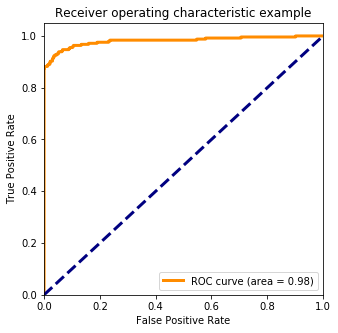

sklearn AUC: 0.981115695653423

xgb_predictor.endpoint = TC58-SW010-WC006-20210405151047

s3_wholedata_path = s3://sagemaker-cn-northwest-1-337575217701/xgb-10000871-part_ac.csv-TC58-SW010-WC006-20210405135629/wholedata/whole_data.csv


(None,)

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
#from xgboost import XGBRegressor
%matplotlib inline
from matplotlib import pyplot
from sklearn.metrics import mean_absolute_error

y_labels = model_data.iloc[:, 0]
y_scores = predictions

#结果 1：测试数据集结果 与 预测结果 的数量对比
print('model_data: 1='+ str((y_labels == 1).sum()) + ', 0='+str((y_labels == 0).sum()) +' / '),
print('predictions Result: 1='+ str((np.round(y_scores) == 1).sum()) + ', 0='+str((np.round(y_scores) == 0).sum()))

#结果 2：交叉表，说明 测试数据集结果 与 预测结果 的正确情况对比
display(pd.crosstab(index=model_data.iloc[:, 0], columns=np.round(predictions), 
            rownames=['model_data'], colnames=['predictions_data'],margins=False))
#print('\n')

#结果 4：ROC图，越大越好，无限接近与1
from sklearn.metrics import roc_curve, auc                     #导入库
fpr, tpr, thresholds  =  roc_curve(y_labels, y_scores)  #计算真正率和假正率
roc_auc = auc(fpr,tpr)                                         #计算auc的值
plt.figure()
lw = 3
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) #假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#结果 3：AUC值，越大越好，无限接近与1
import numpy as np
from sklearn.metrics import roc_auc_score
##y_labels=[0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1.
##y_scores=[4.92438182e-01 1.74370125e-01 8.58997216e-01 1.30175965e-01 
# 调用sklearn中的方法计算AUC，与后面自己写的方法作对比
print('sklearn AUC:', roc_auc_score(y_labels, y_scores))
#打印全局变量值
print('\nxgb_predictor.endpoint = ' + str(xgb_predictor.endpoint)),
print('\ns3_wholedata_path = '+ str(s3_wholedata_path)),

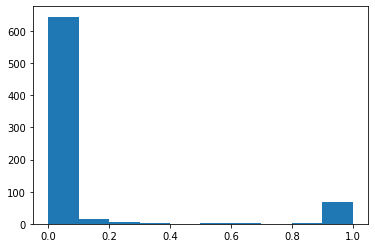

predictions_data,0,1
model_data,,
0.0,663,2
1.0,6,70


In [95]:
#结果 5：分布柱状图；用于分析和优化结果（round函数）；
plt.hist(predictions, bins=10, range=(0, 1))
plt.show()

#用于分析和优化结果（round函数）；
round_predictions=0.45
pd.crosstab(index=model_data.iloc[:, 0], columns=np.where(predictions > round_predictions, 1, 0), 
            rownames=['model_data'], colnames=['predictions_data'],margins=False)


## 结束